# Train a CNN on the color-based training set.
Classify patches from all Y-neg tumors.  
Regain those that are certainly blue or certainly green.  
Try to fix loss=nan problem.  

In [1]:
import time
import os
import glob
import cv2 # OpenCV-Python
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import json
DIR_IMAGES_RAW = "/home/jrm/Martinez/images/raw/"
DIR_IMAGES_OUT = "/home/jrm/Martinez/images/temp/"
PATTERN_IMAGES_RAW = "*.DF1.*.tif"
PATCH_SIZE=224  # matches VGG

In [2]:
DF_Ypos = ['B7.','B15','D1.','D5.','E7.','E9.','F9.','G3.','H13','I1.','I5.','I13']
DF_Yneg = ['A3.','A5.','B13','C1.','C11','D3.','E5.','F3.','F7','F11','F13','F15','G15','H1.','H3.','H7.','H15']

In [3]:
def get_image_names(path,pattern):
    #RAW_IMAGE_NAMES = os.listdir(DIR_IMAGES_RAW)
    paths = glob.glob(path+pattern)
    names = [os.path.basename(x) for x in paths]
    return names
FILENAMES_IMAGES_RAW = get_image_names(DIR_IMAGES_RAW,PATTERN_IMAGES_RAW)
#FILENAMES_IMAGES_RAW

In [4]:
class patch_maker:
    def __init__(self):
        self.path=""
        self.w=0
        self.h=0
        self.im_width = 0
        self.im_height = 0
        self.patch_size = 10 # scalar, assumed square for now
        self.pixel_array = None
    def set_input_path(self,path):
        self.path=path
    def set_patch_size(self,scalar):
        self.patch_size = scalar
    def load_pixel_array(self,filename,verbose=False):
        self.w=0
        self.h=0
        im = Image.open(self.path+filename)
        ima = np.array(im)   # convert to numpy
        self.im_width = ima.shape[0]
        self.im_height = ima.shape[1]    
        if verbose:
            print(filename, ima.size, ima.shape)
        self.pixel_array = ima
        return ima
    def get_next_patch(self): 
        IM_WIDTH = self.im_width
        IM_HEIGHT = self.im_height
        PIXEL_ARRAY = self.pixel_array
        patch = None
        if self.w+self.patch_size > IM_WIDTH:
            self.h += self.patch_size
            self.w = 0
        if self.w+self.patch_size <= IM_WIDTH and self.h+self.patch_size <= IM_HEIGHT:
            patch = PIXEL_ARRAY[self.w:self.w+self.patch_size, self.h:self.h+self.patch_size]
            self.w += self.patch_size
        return patch

In [5]:
NO_GREEN_INTENSITY=np.array( [0,35,0] )
NO_BLUE_INTENSITY=np.array( [0,0,30] )
pm = patch_maker()
pm.set_input_path(DIR_IMAGES_RAW)
pm.set_patch_size(PATCH_SIZE)
X_train=[]
Y_train=[]
X_valid=[]
Y_valid=[]
VMOD=10
pcount=0
BLUE=1
GREEN=0
def add_patch (patch, color):  # TO DO: make this a class, dispense with globals
    global pcount
    global VMOD
    if pcount >= VMOD:
        X_valid.append(patch)
        Y_valid.append(color)
        pcount = 0
    else:
        X_train.append(patch)
        Y_train.append(color)
        pcount += 1
for filename in FILENAMES_IMAGES_RAW:
    prefix = filename[0:3]
    if prefix in DF_Yneg:
        print(filename,end=", ")
        pixels = pm.load_pixel_array(filename)
        patch = pm.get_next_patch()
        while patch is not None:
            num_green_pixels = np.sum(np.all(patch >= NO_GREEN_INTENSITY,axis=2))
            num_blue_pixels = np.sum(np.all(patch >= NO_BLUE_INTENSITY,axis=2))
            if num_blue_pixels>=10000 and num_blue_pixels>num_green_pixels*20:
                add_patch(patch,BLUE)
            elif num_green_pixels>=15000 and num_green_pixels>num_blue_pixels*2:
                add_patch(patch,GREEN)
            patch = pm.get_next_patch()
    break  # FOR STARTERS, JUST PROCESS ONE FILE!
print()
# Required for tensorflow+
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)
X_valid = np.asarray(X_valid)
Y_valid = np.asarray(Y_valid)

F15.DF1.135.tif, 


In [6]:
print(type(X_train))
print(len(X_train))
print(X_train[0].shape)
print(Y_valid)

<class 'numpy.ndarray'>
270
(224, 224, 3)
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]


In [7]:
from tensorflow import keras
import keras.layers as kl
ACTIVATION="tanh"
INPUT_SHAPE=[PATCH_SIZE,PATCH_SIZE,3]
cnn = keras.models.Sequential([
    kl.Conv2D(filters=64,kernel_size=7,activation=ACTIVATION,padding="SAME",
    input_shape=INPUT_SHAPE),
    kl.MaxPooling2D(2),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(128,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2),   
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.Conv2D(256,3,activation=ACTIVATION,padding="same"),
    kl.MaxPooling2D(2), 
    kl.Flatten(),
    kl.Dense(128,activation=ACTIVATION),
    kl.Dropout(0.5),
    kl.Dense(64,activation=ACTIVATION),
    kl.Dropout(0.5),    
    kl.Dense(2,activation="softmax")
])
# 10 nodes in the output layer
# corresponds to 10 classes of MNIST clothes.
# cnn.layers[0].weights

In [8]:
cnn.compile(loss="sparse_categorical_crossentropy",
           optimizer="sgd",
           metrics=["accuracy"])
EPOCHS=10
start = time.time()
hist = cnn.fit(X_train,Y_train,epochs=EPOCHS,
                 validation_data=(X_valid,Y_valid))
end = time.time()
print("Elapsed time:",end-start)

Epoch 1/10
9/9 [==============================] - 38s 4s/step - loss: 0.7018 - accuracy: 0.8111 - val_loss: 0.4730 - val_accuracy: 0.9231
Epoch 2/10
9/9 [==============================] - 37s 4s/step - loss: 0.5779 - accuracy: 0.8815 - val_loss: 0.3770 - val_accuracy: 0.9231
Epoch 3/10
9/9 [==============================] - 39s 4s/step - loss: 0.5281 - accuracy: 0.8704 - val_loss: 0.3280 - val_accuracy: 0.9231
Epoch 4/10
9/9 [==============================] - 37s 4s/step - loss: 0.5280 - accuracy: 0.8704 - val_loss: 0.2906 - val_accuracy: 0.9231
Epoch 5/10
9/9 [==============================] - 41s 5s/step - loss: 0.4539 - accuracy: 0.8741 - val_loss: 0.2834 - val_accuracy: 0.9231
Epoch 6/10
9/9 [==============================] - 39s 4s/step - loss: 0.4406 - accuracy: 0.8593 - val_loss: 0.2769 - val_accuracy: 0.9231
Epoch 7/10
9/9 [==============================] - 37s 4s/step - loss: 0.4354 - accuracy: 0.8741 - val_loss: 0.2728 - val_accuracy: 0.9231
Epoch 8/10
9/9 [==================

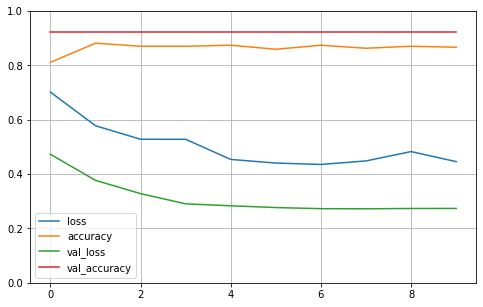

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.0,1.0)
plt.show()

2022-02-08 13:39:32.313479: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-08 13:39:32.313577: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Alien): /proc/driver/nvidia/version does not exist
2022-02-08 13:39:32.314790: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-08 13:39:32.783647: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-02-08 13:39:32.972057: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2022-02-08 13:39:33.075415: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2022-02-08 13:39:34.623417: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2022-02-08 13:39:34.779412: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
